In [6]:
import numpy as np
import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

RANDOM_STATE = 50

In [ ]:
def format_sequence(s):
    """Add spaces around punctuation and remove references to images/citations."""
    
    # Add spaces around punctuation
    s =  re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', s)
    
    # Remove references to figures
    s = re.sub(r'\((\d+)\)', r'', s)
    
    # Remove double spaces
    s = re.sub(r'\s\s', ' ', s)
    return s

def make_sequences(arr,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(arr)

    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    features = tokenizer.texts_to_sequences(arr)
    
    print(f'There are {len(features)} sequences.')

    features = np.array(features)

    return word_idx,idx_word,num_words,word_counts,features

def create_train_valid(features,labels,num_words,train_fraction = 0.7,max_valid=1000):

    features,labels = shuffle(features,labels,random_state = RANDOM_STATE)

    train_end = max(int(train_fraction*len(labels)),len(labels)-max_valid)

    train_features = np.asarray(features[:train_end])
    valid_features = np.asarray(features[train_end:])

    train_labels = np.asarray(labels[:train_end])
    valid_labels = np.asarray(labels[train_end:])
    
    return train_features,valid_features,train_labels,valid_labels

In [ ]:
data = pd.read_csv('dataset.csv').dropna(axis=0,how='any')
# print(data.columns)
data['text'].str.replace('[^a-zA-Z]', ' ')

text = [format_sequence(a) for a in data['text'].to_list()]
labels = data['sarcastic'].to_list()

lower = False
filters = '!"%;[\\]^_`{|}~\t\n'

word_idx,idx_word,num_words,word_counts,features = make_sequences(text,lower,filters)
X_train, X_valid, y_train, y_valid = create_train_valid(features,labels,num_words)
training_dict = {'X_train': X_train, 'X_valid': X_valid,'y_train': y_train, 'y_valid': y_valid}



In [7]:
glove_loc = 'path_to_glove_txt'
glove = np.loadtxt(glove_loc,dtype='str',comments=None)

In [8]:
vectors = glove[:,1:].astype('float')
words = glove[:,0]

del glove

In [9]:
word_lookup = {word:vector for word,vector in zip(words,vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i,word in enumerate(word_idx.keys()):
    vector = word_lookup.get(word,None)

    if vector is not None:
        embedding_matrix[i+1,:] = vector
    else:
        not_found +=1

embedding_matrix = np.nan_to_num(embedding_matrix)

print(f'{not_found} words not found.')

8978 words not found.


In [10]:
model = Sequential()

model.add(Embedding(input_dim=len(word_idx)+1,output_dim=100,weights=[embedding_matrix],trainable=False))

model.add(Bidirectional(LSTM(64,return_sequences=False,dropout=0.3,recurrent_dropout=0.3)))

# model.add(Bidirectional(LSTM(64,return_sequences=False,dropout=0.3,recurrent_dropout=0.1)))

model.add(Dense(64,activation='relu'))

model.add(Dense(32,activation='relu'))

model.add(Dense(16,activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

x = np.array(training_dict['X_train'])
y = np.array(training_dict['y_train']).astype(np.float32)


u = np.array(training_dict['X_valid'])
v = np.array(training_dict['y_valid']).astype(np.float32)

# model = load_model('./models/model1')

u =     pad_sequences(u,padding="post")
x =     pad_sequences(x,padding="post")

print(x.shape,y.shape,u.shape,v.shape)

history = model.fit(x, y, epochs = 100, batch_size = 2048, 
        validation_data = (u,v),
        verbose = 1)

model.save('model1')

model.evaluate(x,y,batch_size=512)
model.evaluate(u,v,batch_size=512)


2022-03-28 09:41:56.817272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-28 09:41:56.817297: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-28 09:41:56.817313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (predator): /proc/driver/nvidia/version does not exist
2022-03-28 09:41:56.817950: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(25709, 42) (25709,) (1000, 28) (1000,)
Epoch 1/100
13/13 [==============================] - 14s 780ms/step - loss: 0.6784 - accuracy: 0.5632 - val_loss: 0.6515 - val_accuracy: 0.6740
Epoch 2/100
13/13 [==============================] - 11s 857ms/step - loss: 0.6456 - accuracy: 0.6354 - val_loss: 0.5872 - val_accuracy: 0.7480
Epoch 3/100
13/13 [==============================] - 9s 677ms/step - loss: 0.5944 - accuracy: 0.6886 - val_loss: 0.5379 - val_accuracy: 0.7500
Epoch 4/100
13/13 [==============================] - 9s 669ms/step - loss: 0.5481 - accuracy: 0.7246 - val_loss: 0.4799 - val_accuracy: 0.7750
Epoch 5/100
13/13 [==============================] - 9s 677ms/step - loss: 0.5142 - accuracy: 0.7575 - val_loss: 0.4580 - val_accuracy: 0.7890
Epoch 6/100
13/13 [==============================] - 10s 744ms/step - loss: 0.4884 - accuracy: 0.7726 - val_loss: 0.4257 - val_accuracy: 0.8120
Epoch 7/100
13/13 [==============================] - 9s 692ms/step - loss: 0.4733 - accuracy: 0.785

2022-03-28 09:56:29.618378: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model1/assets


2/2 [==============================] - 0s 43ms/step - loss: 0.3867 - accuracy: 0.8650


[0.38669508695602417, 0.8650000095367432]

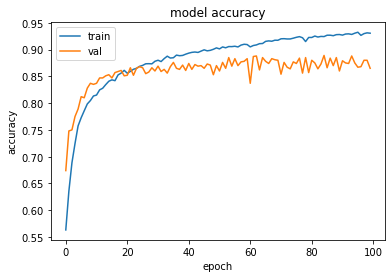

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

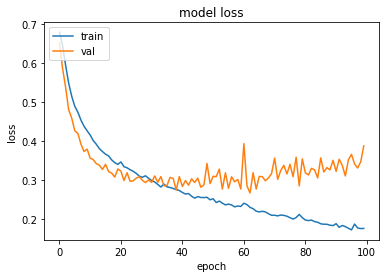

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from IPython.display import Image
model_name = 'model1'
model_dir = './models/'

plot_model(model, to_file=f'{model_dir}{model_name}.png', show_shapes=True)

Image(f'{model_dir}{model_name}.png')



In [ ]:
str = ['']

tokenizer = Tokenizer(lower=lower, filters=filters)
tokenizer.fit_on_texts(str)

tx = tokenizer.texts_to_sequences(str)
print(tx)
print(model.predict(tx)[0])